<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/ncov_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>SARS-Cov-2 Analysis Workflow</h1>

This tutorial implements the best-practices bioinformatics workflow for the assembly of an SARS-CoV-2 viral genomes. The workflow in the document implements the [ARTIC Nanopore bioinformatics SOP](https://https://artic.network/ncov-2019/ncov2019-bioinformatics-sop.html).

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 16 Gb RAM
- An internet connection

> ⚠️ **Warning:** Before starting a new analysis it is recommeded to select `Edit > Clear all outputs` from the menu above before using the notebook.



## Installation

The default **EPI2MELabs** environment does not contain the ARTIC software. To install the software press the play button below to the left hand side (it may appear as `[ ]`):

In [0]:
#@markdown **ARTIC Bioinformatics installation** *(click the play button to install)*
import os
%cd /home/jovyan
if os.path.exists("artic-ncov2019"):
    print("Found existing install, removing.")
    !rm -rf artic-ncov2019
print("Downloading ARTIC")
!git clone https://github.com/artic-network/artic-ncov2019.git
print("Installating ARTIC")
%cd artic-ncov2019
!/opt/conda/bin/conda env remove -n artic-ncov2019-medaka
!/opt/conda/bin/conda env create -f environment-medaka.yml

## Analysis

The workflow requires `.fastq` files from an Oxford Nanopore Technologies' sequencing device. These should not have previously been trimmed or demultiplexed, as this will be performed as part of the workflow.

To find the correct full path your data navigate to it in the Files browser to the left-hand side of this page, right-click on the folder and select Copy path:


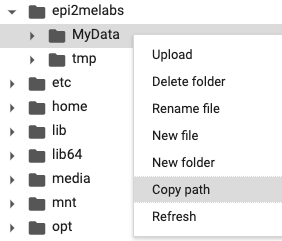

The input folder should be the top level folder output containing the `fastq_pass` folder and `sequencing_summary.txt` file.

In [0]:
#@markdown **Analysis Parameters** *(fill in the required values and then press play)*
import glob
import os
import shutil

from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'ncov_tutorial')

bashgreen = "\e[1m\e[32m"
bashred = "\e[1m\e[31m"
bashdefault = "\e[0m\e[39m"
debug = True
ref_name = "MN908947.3"
ref_len = 29903

def error(text):
    return "\033[1;31m{}\033[0;39m".format(text)
def good(text):
    return "\033[1;32m{}\033[0;39m".format(text)

input_folder = "/epi2melabs/ncov" #@param {type:"string"}
output_folder = "/epi2melabs/analysis/" #@param {type:"string"}
run_name = "run0" #@param {type:"string"}
overwrite = False #@param {type:"boolean"}
threads = 8 #@param {type:"integer"}
primer_set = "V3" #@param ["V1", "V2", "V3"]
minimum_reads = 30000 #@param {type:"integer"}
min_read_length = 400 #@param {type:"integer"}
max_read_length = 700 #@param {type:"integer"}

success = True

msg_lines = []
# check input folder
if not os.path.exists(input_folder):
    msg = "`{}` does not exist.".format(input_folder)
    success = False
else:
    msg = input_folder
msg_lines.append("Input folder:  {}".format(msg))

# check fastq_pass folder
fastq_pass = os.path.join(input_folder, 'fastq_pass')
if not os.path.exists(fastq_pass):
    msg = error("fastq_pass folder not found under {}.".format(input_folder))
    success = False
else:
    msg = fastq_pass
msg_lines.append("fastq folder:  {}".format(msg))

# check summary file
seqsum_glob = "sequencing_summary_*_*.txt"
seqsums = glob.glob(os.path.join(input_folder, seqsum_glob))
if len(seqsums) == 0:
    msg = error("No file matching {} under {}.".format(seqsum_glob, input_folder))
    success = False
else:
    seq_summary_file = seqsums[0]
    msg = seq_summary_file
msg_lines.append("seq. summary:  {}".format(msg))

# check output
if os.path.exists(output_folder) and not overwrite:
    msg = error("{} exists, overwrite not selected".format(output_folder))
    success = False
else:
    if os.path.exists(output_folder):
        print("- Previous output folder exists, removing")
        try:
            shutil.rmtree(output_folder)
        except:
            print(error('- Error while deleting directory'))
    os.mkdir(output_folder)
    msg = output_folder
msg_lines.append("Output folder: {}".format(msg))

print()
print("Configuration")
print("-------------")
for line in msg_lines:
    print(line)
if success:
    print(good("Inputs setup correctly."))
else:
    print(error("One of more errors occurred finding inputs."))



Configuration
-------------
Input folder:  /epi2melabs/ncov
fastq folder:  /epi2melabs/ncov/fastq_pass
seq. summary:  /epi2melabs/ncov/sequencing_summary_FAN38516_dsampled.txt
Output folder: /epi2melabs/analysis/
Inputs setup correctly.


### Demultiplexing and Read Quality Control

The following section of this report will run sample demultiplexing using the
`guppy_barcoder` software. The results of this will appear in the output folder under the `demultiplex` folder. After demultiplexing a rerport is produced by merging results of the demultiplexing with the "sequencing summary" file from the original MinKNOW output.

Use the code cell below to run the demultiplexing:

In [0]:
#@markdown **Running Guppy demultiplexing** *(press play)*
!rm -rf $output_folder/demultiplex
!guppy_barcoder \
    --require_barcodes_both_ends --arrangements_files "barcode_arrs_nb12.cfg barcode_arrs_nb24.cfg" \
    --compress_fastq --records_per_fastq 0 --recursive --worker_threads 8 \
    --save_path $output_folder/demultiplex \
    --input_path $input_folder \
    && echo "$bashgreen"Guppy finished successfully"$bashdefault" \
    || echo "$bashred"Guppy failed"$bashdefault"


ONT Guppy barcoding software version 3.5.2+5b7a51b
input path:         /epi2melabs/ncov
save path:          /epi2melabs/analysis//demultiplex
arrangement files:  barcode_arrs_nb12.cfg barcode_arrs_nb24.cfg
min. score front:   60
min. score rear:    60


Found 100 fastq files.

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Done in 98881 ms.
Guppy finished successfully


The demultiplexing produces a summary file recording the barcode found in each read, or "unclassified" if the barcodes could not be confidently identified.

In [0]:
#@markdown **Merging data files** *(press play)*
import pandas as pd

success = False
bc_summary, seq_summary = None, None
barcode_summary_file = os.path.join(output_folder, "demultiplex", "barcoding_summary.txt")
if not os.path.exists(barcode_summary_file):
    print(error("Could not find barcode summary: {}.".format(barcode_summary_file)))
else:
    print("Reading demultiplex summary: {}.".format(barcode_summary_file))
    try:
        bc_summary = pd.read_csv(barcode_summary_file, sep='\t')
    except Exception as e:
        print(error("Could not read barcode summary: {}".format(barcode_summary)))
        if debug:
            raise e

print("Reading sequencing summary: {}".format(seq_summary_file))
try:
    seq_summary = pd.read_csv(seq_summary_file, sep='\t')
except Exception as e:
    print(error("Could not read barcode summary: {}".format(seq_summary_file)))
    if debug:
        raise e

if not any(x is None for x in (bc_summary, seq_summary)):
    print("Merging barcode and sequencing summaries.")
    try:
        summary = pd.merge(bc_summary, seq_summary, on='read_id')
    except Exception as e:
        print(error("Could not merge files."))
        if debug:
            print(e)
    else:
        success = True
if success:
    print(good("Sequencing and barcode summaries read and merged."))
else:
    print(error("One or more errors occurred reading input files."))

Reading demultiplex summary: /epi2melabs/analysis/demultiplex/barcoding_summary.txt.
Reading sequencing summary: /epi2melabs/ncov/sequencing_summary_FAN38516_dsampled.txt
Merging barcode and sequencing summaries.
Sequencing and barcode summaries read and merged.


To generate a QC report, run the cell below:



In [0]:
#@markdown **Reads QC Report** *(press play)*
import aplanat
from aplanat import bars, hist, annot
from bokeh.models import Span
from bokeh.layouts import gridplot
import numpy as np

plots = list()

total_bases = seq_summary['sequence_length_template'].sum()
mean_length = total_bases / len(seq_summary)
median_length = np.median(seq_summary['sequence_length_template'])

# read length plot
datas = [summary['sequence_length_template']]
length_hist = hist.histogram(
    datas, bins=400,
    title="Read length distribution.",
    x_axis_label='Read Length / bases',
    y_axis_label='Number of reads',
    xlim=(0, 2000))
length_hist = annot.subtitle(
    length_hist,
    "Mean: {:.0f}. Median: {:.0f}".format(
        mean_length, median_length))
plots.append(length_hist)

# barcode count plot
barcode_counts = pd.DataFrame(summary['barcode_arrangement'].value_counts()) \
    .sort_index().reset_index().rename(
        columns={'index':'barcode', 'barcode_arrangement':'count'})
bc_counts = bars.simple_bar(
    barcode_counts['barcode'], barcode_counts['count'],
    title='Number of reads per barcode')
bc_counts = annot.subtitle(
    bc_counts,
    'Barcodes with fewer than {} reads will not be analysed further.'.format(
        minimum_reads))
bc_counts.xaxis.major_label_orientation = 3.14/2
bc_counts = annot.marker_hline(bc_counts, minimum_reads)
plots.append(bc_counts)

# determine which barcode datasets are good
barcode_counts['sufficient data'] = barcode_counts['count'] > minimum_reads
valid_barcodes = set(
    barcode_counts.loc[barcode_counts['sufficient data']]['barcode'])

aplanat.show(gridplot(plots))

### Run ARTIC for each sample

With demultiplexed reads, we are in a position to analyse each dataset independently using the ARTIC workflow.

In [0]:
#@markdown **Run ARTIC analysis for each barcode** *(press play)*
def run_artic(
        barcode, directory, artic_output,
        min_len=400, max_len=700, run_name="run0", threads=8,
        scheme="V3"):
    !mkdir -p $artic_output/$barcode
    prefix = os.path.join(artic_output, barcode, run_name)
    log_file = "{}_artic.log".format(prefix)
    read_file = "{}_{}.fastq".format(prefix, barcode)
    print("Writing log file to: {}.".format(log_file))
    # read filtering
    print("Running artic guppyplex to filter reads")
    !run artic guppyplex --skip-quality-check \
        --min-length $min_len --max-length $max_len \
        --directory $directory --prefix $prefix >>$log_file 2>&1 \
        && echo "$bashgreen"artic guppyplex run successfully"$bashdefault" \
        || echo "$bashred"artic guppyplex failed"$bashdefault"
    # run everything else
    print("Running artic minion --medaka to call variants")
    !run artic minion --medaka --normalise 200 --threads $threads \
        --scheme-directory /home/jovyan/artic-ncov2019/primer_schemes \
        --read-file $read_file nCoV-2019/$scheme \
        $prefix >>$log_file 2>&1 \
        && echo "$bashgreen"artic minion run successfully"$bashdefault" \
        || echo "$bashred"artic minion failed"$bashdefault"
    print("Running alignment QC")
    try:
        for i in (1,2):
            bam = "{}.primertrimmed.nCoV-2019_{}.sorted.bam".format(prefix, i)
            !stats_from_bam $bam > $bam".stats"
            !coverage_from_bam -s 50 -p $bam $bam
    except Exception as e:
        print(error("Alignment summary failed."))
    else:
        print(good("Alignment summary complete."))
    return prefix

# setup artic output
artic_output = os.path.join(output_folder, "artic")

# run analysis for each barcode
valid_barcodes = barcode_counts.loc[barcode_counts['sufficient data']]['barcode']
for barcode in valid_barcodes:
    msg = "Running ARTIC analysis for: {}".format(barcode)
    print(msg)
    print("-" * len(msg))
    print()
    artic_input = os.path.join(output_folder, "demultiplex", barcode)
    out_prefix = run_artic(
        barcode, artic_input, artic_output,
        min_len=min_read_length, max_len=max_read_length, run_name=run_name, 
        threads=threads, scheme=primer_set)
    print("Results for {} can be found at {}".format(barcode, out_prefix))
    msg = "ARTIC finished for: {}".format(barcode)
    print(msg)
    print("=" * len(msg))
    print()

Running ARTIC analysis for: barcode01
-------------------------------------

Writing log file to: /epi2melabs/analysis/artic/barcode01/run0_artic.log.
Running artic guppyplex to filter reads
artic guppyplex run successfully
Running artic minion --medaka to call variants
artic minion run successfully
Running alignment QC
Mapped/Unmapped/Short/Masked: 12723/0/0/0
[11:20:52 - root] Processing region MN908947.3:0-29900
Mapped/Unmapped/Short/Masked: 12227/0/0/0
[11:20:56 - root] Processing region MN908947.3:0-29900
Alignment summary complete.
Results for barcode01 can be found at /epi2melabs/analysis/artic/barcode01/run0
ARTIC finished for: barcode01

Running ARTIC analysis for: barcode02
-------------------------------------

Writing log file to: /epi2melabs/analysis/artic/barcode02/run0_artic.log.
Running artic guppyplex to filter reads
artic guppyplex run successfully
Running artic minion --medaka to call variants
artic minion run successfully
Running alignment QC
Mapped/Unmapped/Short/M

The ARTIC worflow produces the following files for each barcode (*\<run_name>* is the value given at the top of this page):

1. `<run_name>.rg.primertrimmed.bam` - BAM file for visualisation after primer-binding site trimming
2. `<run_name>.trimmed.bam` - BAM file with the primers left on (used in variant calling)
3. `<run_name>.merged.vcf` - all detected variants in VCF format
4. `<run_name>.pass.vcf.gz` - detected variants in VCF format passing quality filter
5. `<run_name>.fail.vcf` - detected variants in VCF format failing quality filter
6. `<run_name>.primers.vcf` - detected variants falling in primer-binding regions
7. `<run_name>.consensus.fasta` - consensus sequence

These will be present in folders named as:

    <output_folder>/analysis/artic/<barcode>/

where `<output_folder>` is the value given at the top of this page and `<barcode>` is the identified barcode for each dataset.

#### Brief summary of results

Running the below will produce a simple tabular summary for each barcoded dataset.

In [0]:
#@markdown **ARTIC Summary Table** *(click play)*
from collections import Counter, defaultdict
import gzip
from pysam import FastxFile
from Bio import SeqIO

results = defaultdict(dict)
for barcode in ('barcode{:02}'.format(x) for x in range(1,25)):
    if not barcode in valid_barcodes:
        results[barcode]["Ns"] = 'NA'
        results[barcode]['variants'] = 'NA'
        continue
    consensus_file = os.path.join(
        artic_output, barcode, "{}.consensus.fasta".format(run_name))
    vcf_file = os.path.join(
        artic_output, barcode, "{}.pass.vcf.gz".format(run_name))
    recs = 0
    for record in SeqIO.parse(consensus_file, "fasta"):
        recs += 1
        results[barcode]["Ns"] = record.seq.count("N")
    if recs != 1:
        raise ValueError(
            "Did not find correct number of records in {}.".format(
                consensus_file))
    variants = 0
    with gzip.open(vcf_file) as vcf:
        for line in (x.decode() for x in vcf):
            if line.startswith('#'):
                continue
            variants += 1
    results[barcode]['variants'] = variants

part1 = ['barcode{:02}'.format(x) for x in range(1,13)]
part2 = ['barcode{:02}'.format(x) for x in range(13,25)]
df = pd.DataFrame.from_dict(results)
display(df[part1])
display(df[part2])
    

,barcode01,barcode02,barcode03,barcode04,barcode05,barcode06,barcode07,barcode08,barcode09,barcode10,barcode11,barcode12
Ns,3260,4551,7392,9203,NA,NA,2999,3960,7417,12158,NA,NA
variants,0,0,0,0,NA,NA,4,4,3,2,NA,NA


,barcode13,barcode14,barcode15,barcode16,barcode17,barcode18,barcode19,barcode20,barcode21,barcode22,barcode23,barcode24
Ns,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
variants,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### QC Summary of ARTIC pipeline results

The results of the ARTIC pipeline include alignment of the reads to a reference genome. A summary of these alignments is produced by the section below. Things to look for here include even coverage of amplicons and that the negative control sample shows little to no data.

In [0]:
#@markdown **Collate ARTIC alignment statistics** *(press play)*
from aplanat import lines
from aplanat import util

pinger.send_notebook_ping('stop', 'ncov_tutorial')

bam_name = ".primertrimmed.nCoV-2019_{}.sorted.bam"
cover_suffix = "_{}_0_{}.depth.txt".format(ref_name, ref_len)
stats_suffix = ".stats"

dfs_cover = list()
dfs_stats = list()
for barcode in valid_barcodes:
    stats_stem = os.path.join(artic_output, barcode, run_name)
    for i in (1,2):
        df = pd.read_csv(stats_stem + bam_name.format(i) + cover_suffix, sep='\t')
        df['primer_set'] = i
        df['barcode'] = barcode
        dfs_cover.append(df)
        df = pd.read_csv(stats_stem + bam_name.format(i) + stats_suffix, sep='\t')
        df['primer_set'] = i
        df['barcode'] = barcode
        dfs_stats.append(df)
cover_summary = pd.concat(dfs_cover)
stats_summary = pd.concat(dfs_stats)
dfs_cover, dfs_stats = None, None

In [0]:
#@markdown **Show coverage histograms** *(press play)*
plots = list()
df = cover_summary
depth_lim = 100
for barcode in valid_barcodes:
    pset = df['primer_set']
    bc = df['barcode'] == barcode
    xs = [df.loc[(pset == i) & bc]['pos'] for i in (1,2)]
    ys = [df.loc[(pset == i) & bc]['depth'] for i in (1,2)]
    
    depth = df[bc].groupby('pos')['depth'].sum()
    depth_thresh = 100*(depth >= depth_lim).sum() / len(depth)

    plot = lines.line(
        xs, ys, colors=['blue', 'red'],
        title="{}: {:.0f}X, {:.1f}% > {}X".format(
            barcode, depth.mean(), depth_thresh, depth_lim),
        height=200, width=400,
        x_axis_label='position', y_axis_label='depth')
    plots.append(plot)
aplanat.show(gridplot(plots, ncols=3))

In [0]:
#@markdown **Show basecall accuracies** *(press play)*
plots = list()
df = stats_summary
for barcode in valid_barcodes:
    pset = df['primer_set']
    bc = df['barcode'] == barcode
    xs, ys = zip(*[
        util.kernel_density_estimate(df.loc[(pset == i) & bc]['acc'])
        for i in (1,2)])
    plot = lines.line(
        list(xs), list(ys), colors=['blue', 'red'],
        title=barcode,
        height=200, width=400,
        x_axis_label='read accuracy', y_axis_label='density')
    plots.append(plot)
aplanat.show(gridplot(plots, ncols=3))